In [152]:
!pip install xgboost

In [153]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [189]:
import pandas as pd
import pickle
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline

from sklearn.dummy import DummyClassifier
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import plotly.express as px


df = pd.read_csv('/content/drive/MyDrive/Alura/3-EstadisticasyMachineLearningG8ONE/8-ChallengeTelecomXPT2/TelecomXPT2DatLimp.csv')
df.drop(columns=['Id_Cliente'], inplace=True)

In [155]:
px.box(df, x = 'pago_total', color = 'abandonó_del_servicio').show()

px.box(df, x = 'pagos_mensuales', color = 'abandonó_del_servicio').show()

px.box(df, x = 'meses_permanencia', color = 'abandonó_del_servicio').show()

In [156]:
# Codificación
xVar = df.drop(columns=['abandonó_del_servicio'])
yVarObj = df['abandonó_del_servicio']
columCateg = xVar.select_dtypes(include='object').columns.tolist()

oneHot = make_column_transformer((OneHotEncoder(drop='if_binary'), columCateg), remainder='passthrough', verbose_feature_names_out=False)
xEncoded = oneHot.fit_transform(xVar)
xBinDF = pd.DataFrame(xEncoded, columns=oneHot.get_feature_names_out(xVar.columns))

encoder = LabelEncoder()
yVarObjBin = encoder.fit_transform(yVarObj)
dfBin = pd.concat([pd.DataFrame({'abandonó_del_servicio': yVarObjBin}), xBinDF], axis=1)
#print(f'Variables binarizadas',dfBin)

# Verificación de la proporción de cancelación
propCancel = df['abandonó_del_servicio'].value_counts(normalize=True)*100
#print(f'proporcion de la varbariable objetivo:\n', propCancel)


# Análisis de correlación con la variable objetivo
correVarObj = dfBin.corr()['abandonó_del_servicio'].sort_values(ascending=False)
#print("Correlación con la variable objetivo:")
#print(correVarObj)

x = dfBin.drop(columns=['abandonó_del_servicio'])
y = dfBin['abandonó_del_servicio']

# Estratificado para mantener proporciones
x, x_test, y, y_test = train_test_split(x, y,stratify=y, test_size = 0.15, random_state = 5)
x_train, x_val, y_train, y_val = train_test_split(x, y,stratify=y, random_state = 5)
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)

# print("\nDistribución en train:", y_train.value_counts(normalize=True))
# print("Distribución en test:", y_test.value_counts(normalize=True))

#Balanceo de Clases
undersampler = RandomUnderSampler(random_state=42)
xTrainBal, yTrainBal = undersampler.fit_resample(x_train, y_train)

#print("\nDistribución después de undersampling:", yTrainBal.value_counts())

In [157]:
dfBinBal = pd.concat([pd.Series(yTrainBal, name=yVarObj.name), pd.DataFrame(xTrainBal)], axis=1)

# Correlación con variable objetivo
srCorr = dfBinBal.corr()[yVarObj.name].sort_values(ascending=False)*100
dfCorr = pd.DataFrame((srCorr.reset_index().rename(columns={'index': 'Servicios', yVarObj.name: 'Porcentaje_Correlación'})))
dfCorrObj = dfCorr[(dfCorr['Porcentaje_Correlación'] >= 5) &(dfCorr['Porcentaje_Correlación'] < 100)]

In [158]:
columCategBin = dfCorrObj['Servicios'].values.tolist()

In [159]:
# Modelos
dummy = DummyClassifier()
dummy.fit(xTrainBal, yTrainBal)

## Modelo de Árbol
modeloArbol = DecisionTreeClassifier(max_depth=3, random_state=5)
modeloArbol.fit(xTrainBal, yTrainBal)
## Modelo Bosques aleatorios
mdRanArb = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
mdRanArb.fit(xTrainBal, yTrainBal)
## Modelo KNN
scaler = MinMaxScaler()
xTrainBal_norm = scaler.fit_transform(xTrainBal)
x_test_norm = scaler.transform(x_test)
knn = KNeighborsClassifier()
knn.fit(xTrainBal_norm, yTrainBal)
## Modelo SVC
svmModel = SVC(kernel='rbf', C=1.0, gamma='scale') # Crear clasificador SVM
svmModel.fit(xTrainBal_norm, yTrainBal)

SVC()

In [160]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [161]:
### Convertir datos a formato DMatrix (óptimo para XGBoost)
dtrain = xgb.DMatrix(xTrainBal_norm, label=yTrainBal)
dtest = xgb.DMatrix(x_test, label=y_test)

In [162]:
params = {
    'objective': 'binary:logistic',  # para clasificación binaria
    'max_depth': 3,                  # profundidad máxima de los árboles
    'learning_rate': 0.1,            # tasa de aprendizaje
    'subsample': 0.8,                # % porcentaje de muestras usado por árbol
    'colsample_bytree': 0.8,         # % porcentaje de características usadas por árbol
    'eval_metric': 'logloss',        # métrica de evaluación
    'seed': 42                       # semilla para reproducibilidad
}

# Entrenar el modelo
num_round = 100  # número de iteraciones (árboles)
mdXgboost = xgb.train(params, dtrain, num_round)

# Validando el modelos

In [165]:
from sklearn.metrics import confusion_matrix

In [166]:
from sklearn.metrics import ConfusionMatrixDisplay

#### Modelo dummy

In [167]:
yPrevisto = modelo.predict(x_val)
matrizConfusion = confusion_matrix(y_val,yPrevisto)

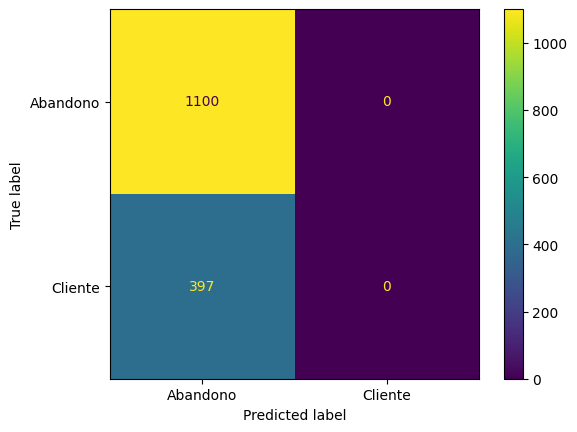

In [168]:
visualizacion = ConfusionMatrixDisplay(confusion_matrix = matrizConfusion, display_labels=['Abandono','Cliente'])
visualizacion.plot();

In [169]:
print(f'La precisión del modelo dummy es: {dummy.score(x_test, y_test):.4f}')
print(f'La sensibilidad (Recall) del modelo es:{recall_score(y_val, yPrevisto):.4f}')
print(f'La exactitud (accuracy) del modelo es:{accuracy_score(y_val, yPrevisto):.4f}')
print(f'El F1-score del modelo es: {f1_score(y_val,yPrevisto)}')

La precisión del modelo dummy es: 0.7351
La sensibilidad (Recall) del modelo es:0.0000
La exactitud (accuracy) del modelo es:0.7348
El F1-score del modelo es: 0.0


#### Modelo de árbol

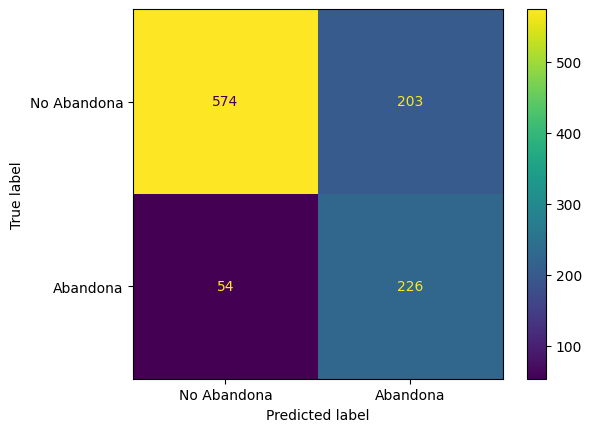

In [170]:
yPredArbol = modeloArbol.predict(x_test)
matriz = confusion_matrix(y_test, yPredArbol)
ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=["No Abandona", "Abandona"]).plot()

In [171]:
print(f'La sensibilidad (Recall) del modelo es:{recall_score(y_test, yPredArbol):.4f}')
print(f'La exactitud (accuracy) del modelo es:{accuracy_score(y_test, yPredArbol):.4f}')
print(f'El F1-score del modelo es: {f1_score(y_test,yPredArbol):.4f}')

La sensibilidad (Recall) del modelo es:0.8071
La exactitud (accuracy) del modelo es:0.7569
El F1-score del modelo es: 0.6375


#### Modelo bosques aleatorios

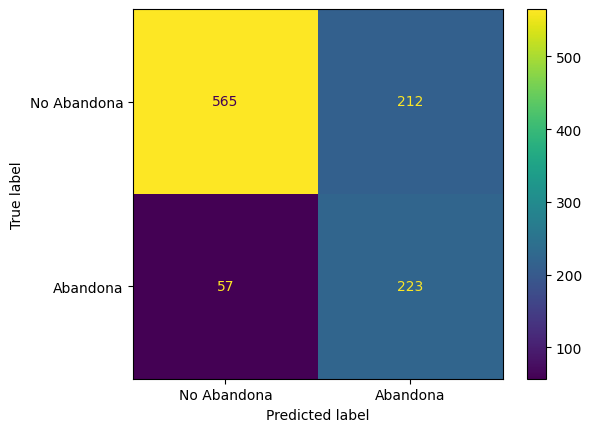

In [172]:
yPredBosqAlt = mdRanArb.predict(x_test)
matriz = confusion_matrix(y_test, yPredBosqAlt)
ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=["No Abandona", "Abandona"]).plot()

In [173]:
print(f'La sensibilidad (Recall) del modelo es:{recall_score(y_test, yPredBosqAlt):.4f}')
print(f'La exactitud (accuracy) del modelo es:{accuracy_score(y_test, yPredBosqAlt):.4f}')
print(f'El F1-score del modelo es: {f1_score(y_test,yPredBosqAlt):.4f}')

La sensibilidad (Recall) del modelo es:0.7964
La exactitud (accuracy) del modelo es:0.7455
El F1-score del modelo es: 0.6238


##### Modelo KNN

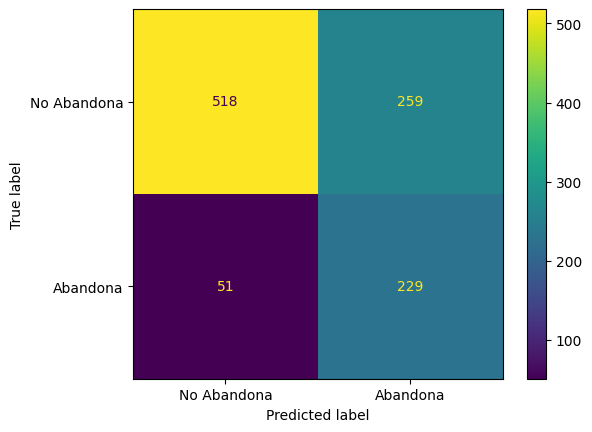

In [175]:
yPredKnn = knn.predict(x_test_norm)
matriz = confusion_matrix(y_test, yPredKnn)
ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=["No Abandona", "Abandona"]).plot()

In [176]:
print(f'La sensibilidad (Recall) del modelo es:{recall_score(y_test, yPredKnn):.4f}')
print(f'La exactitud (accuracy) del modelo es:{accuracy_score(y_test, yPredKnn):.4f}')
print(f'El F1-score del modelo es: {f1_score(y_test,yPredKnn):.4f}')

La sensibilidad (Recall) del modelo es:0.8179
La exactitud (accuracy) del modelo es:0.7067
El F1-score del modelo es: 0.5964


##### Modelo SVM

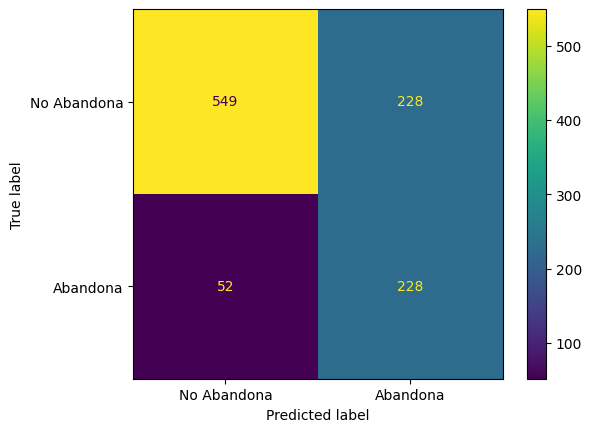

In [177]:
yPredSvm = svmModel.predict(x_test_norm)
matriz = confusion_matrix(y_test, yPredSvm)
ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=["No Abandona", "Abandona"]).plot()

In [178]:
print(f'La sensibilidad (Recall) del modelo es:{recall_score(y_test, yPredSvm):.4f}')
print(f'La exactitud (accuracy) del modelo es:{accuracy_score(y_test, yPredSvm):.4f}')
print(f'El F1-score del modelo es: {f1_score(y_test,yPredSvm):.4f}')

La sensibilidad (Recall) del modelo es:0.8143
La exactitud (accuracy) del modelo es:0.7351
El F1-score del modelo es: 0.6196


## Métricas de evaluación

![](https://drive.google.com/uc?id=1PGEy9Su3gvRZ1X8jeaiSrg2MwZZ0dx1T)


$$
 \text{precision} = \frac{TP}{TP + FP}
 $$


$$
\text{recall} = \frac{TP}{TP + FN}
$$

$$
F1 = \frac{2 \times \text{precision} \times \text{recall}}{\text{precision} + \text{recall}}
$$
$$
\text{accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$
$$
\text{specificity} = \frac{TN}{TN + FP}
$$



### Métricas de evaluación

#### Modelo Árbol

In [179]:
print(f'La precisión del modelo Árbol es: {modeloArbol.score(x_test, y_test):.4f}')
print(f'La sensibilidad (Recall) del modelo es:{recall_score(y_test, yPredArbol):.4f}')
print(f'La exactitud (accuracy) del modelo es:{accuracy_score(y_test, yPredArbol):.4f}')
print(f'El F1-score del modelo es: {f1_score(y_test,yPredArbol):.4f}')

La precisión del modelo Árbol es: 0.7569
La sensibilidad (Recall) del modelo es:0.8071
La exactitud (accuracy) del modelo es:0.7569
El F1-score del modelo es: 0.6375


#### Modelo Bosque aleatorios

In [180]:
print(f'La precisión del modelo Bosques aleatorios es: {mdRanArb.score(x_test, y_test):.4f}')
print(f'La sensibilidad (Recall) del modelo es:{recall_score(y_test, yPredBosqAlt):.4f}')
print(f'La exactitud (accuracy) del modelo es:{accuracy_score(y_test, yPredBosqAlt):.4f}')
print(f'El F1-score del modelo es: {f1_score(y_test,yPredBosqAlt):.4f}')

La precisión del modelo Bosques aleatorios es: 0.7455
La sensibilidad (Recall) del modelo es:0.7964
La exactitud (accuracy) del modelo es:0.7455
El F1-score del modelo es: 0.6238


#### Modelo Knn

In [181]:
print(f'La precisión del modelo KNN es: {knn.score(x_test_norm, y_test):.4f}')
print(f'La sensibilidad (Recall) del modelo es:{recall_score(y_test, yPredKnn):.4f}')
print(f'La exactitud (accuracy) del modelo es:{accuracy_score(y_test, yPredKnn):.4f}')
print(f'El F1-score del modelo es: {f1_score(y_test,yPredKnn):.4f}')

La precisión del modelo KNN es: 0.7067
La sensibilidad (Recall) del modelo es:0.8179
La exactitud (accuracy) del modelo es:0.7067
El F1-score del modelo es: 0.5964


#### Modelo SVM

In [182]:
print(f'La precisión del modelo SVC es: {svmModel.score(x_test_norm, y_test):.4f}')
print(f'La sensibilidad (Recall) del modelo es:{recall_score(y_test, yPredSvm):.4f}')
print(f'La exactitud (accuracy) del modelo es:{accuracy_score(y_test, yPredSvm):.4f}')
print(f'El F1-score del modelo es: {f1_score(y_test,yPredSvm):.4f}')

La precisión del modelo SVC es: 0.7351
La sensibilidad (Recall) del modelo es:0.8143
La exactitud (accuracy) del modelo es:0.7351
El F1-score del modelo es: 0.6196


#### Métricas de modelo XGBoots


🔎 Evaluando modelo: Xgboost
📌 Accuracy : 0.7644
📌 Precision: 0.5370
📌 Recall   : 0.8036
📌 F1-score : 0.6438

📄 Reporte de clasificación:
              precision    recall  f1-score   support

 No Abandona       0.91      0.75      0.82       777
    Abandona       0.54      0.80      0.64       280

    accuracy                           0.76      1057
   macro avg       0.73      0.78      0.73      1057
weighted avg       0.81      0.76      0.78      1057

📊 Predicciones únicas: (array([0, 1]), array([638, 419]))


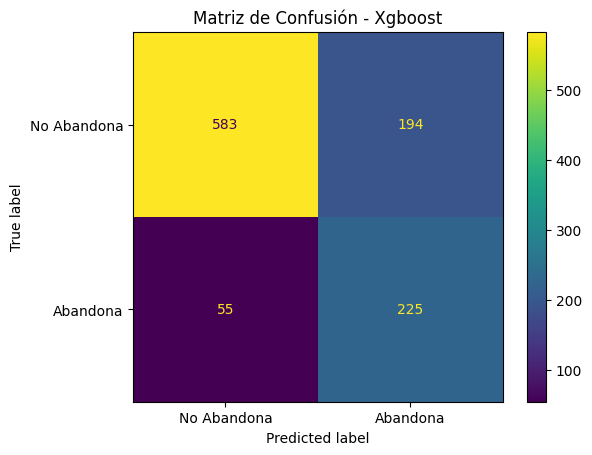

In [190]:
def evaluar_modelo(nombre, modelo, x_test, y_test, normalizado=False):
    print(f"\n🔎 Evaluando modelo: {nombre}")

    # Usar datos normalizados si es necesario
    datos = x_test_norm if normalizado else x_test

    # Predicción para XGBoost
    dtest = xgb.DMatrix(datos)
    y_pred = modelo.predict(dtest)
    y_pred = [1 if p > 0.5 else 0 for p in y_pred]

    # Métricas
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Reporte de clasificación
    print(f"📌 Accuracy : {acc:.4f}")
    print(f"📌 Precision: {prec:.4f}")
    print(f"📌 Recall   : {rec:.4f}")
    print(f"📌 F1-score : {f1:.4f}")
    print("\n📄 Reporte de clasificación:")
    print(classification_report(y_test, y_pred, target_names=["No Abandona", "Abandona"]))

    # Distribución de predicciones
    print("📊 Predicciones únicas:", np.unique(y_pred, return_counts=True))

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Abandona", "Abandona"])
    disp.plot()
    plt.title(f"Matriz de Confusión - {nombre}")
    plt.show()

# Evaluar solo el modelo XGBoost
evaluar_modelo('Xgboost', mdXgboost, x_test, y_test, normalizado=True)

El modelo XGBoost es efectivo para detectar abandonos (Recall=0.80), pero requiere ajustes para reducir falsas alarmas (FP). Prioriza la métrica según el impacto empresarial:

- Evitar FN (Recall): Mantén XGBoost y optimiza el threshold.

- Evitar FP (Precisión): Prueba class_weight o usa Bosques Aleatorios.

#### Precisión de los modelos

In [196]:
modelos = [('Dummy', dummy, x_test), ('Árbol', modeloArbol, x_test), ('Bosques aleatorios', mdRanArb, x_test), ('KNN', knn, x_test_norm), ('SVC', svmModel, x_test_norm)]
_ = list(print(f'La precisión del modelo {nombre} es: {modelo.score(datos, y_test):.4f}') for nombre, modelo, datos in modelos)

La precisión del modelo Dummy es: 0.7351
La precisión del modelo Árbol es: 0.7569
La precisión del modelo Bosques aleatorios es: 0.7455
La precisión del modelo KNN es: 0.7067
La precisión del modelo SVC es: 0.7351


In [195]:
# Evaluación
modelos = [('Dummy', dummy, x_test), ('Árbol', modeloArbol, x_test),('Bosques aleatorios',mdRanArb,x_test), ('KNN', knn, x_test_norm),('SVC',svmModel,x_test_norm)]
for nombre, modelo, datos in modelos:
    print(f'La precisión del modelo {nombre} es: {modelo.score(datos, y_test):.4f}')

La precisión del modelo Dummy es: 0.7351
La precisión del modelo Árbol es: 0.7569
La precisión del modelo Bosques aleatorios es: 0.7455
La precisión del modelo KNN es: 0.7067
La precisión del modelo SVC es: 0.7351


##### Desempeño de los modelos

El desempeño de los modelos entre más lejos este el valor de uno (1) es que presenta peor desempeño.

In [205]:
modelos = [('Árbol', yPredArbol),('BosquesAleatorios', yPredBosqAlt), ('KNN', yPredKnn),('SVC', yPredSvm)]
for nombre, datos in modelos:
    print(f'Desempeño del modelo {nombre} es: {f1_score(y_test,datos):.4f}')

Desempeño del modelo Árbol es: 0.6375
Desempeño del modelo BosquesAleatorios es: 0.6238
Desempeño del modelo KNN es: 0.5964
Desempeño del modelo SVC es: 0.6196


# Curva ROC (Caracteristica Operativa del Receptor)

In [185]:
# Guardar los modelos CORRECTAMENTE (usando los nombres originales)
with open('/content/drive/MyDrive/Alura/3-EstadisticasyMachineLearningG8ONE/8-ChallengeTelecomXPT2/modeloOnehotEncoderTelecomXChurn.pkl', 'wb') as archivo:
    pickle.dump(oneHot, archivo)

with open('/content/drive/MyDrive/Alura/3-EstadisticasyMachineLearningG8ONE/8-ChallengeTelecomXPT2/modeloChampionArbolTelecomXChurn.pkl', 'wb') as archivo:
    pickle.dump(modeloArbol, archivo)

In [186]:
# Cargar los modelos (usa el mismo nombre)
oneHot = pd.read_pickle('/content/drive/MyDrive/Alura/3-EstadisticasyMachineLearningG8ONE/8-ChallengeTelecomXPT2/modeloOnehotEncoderTelecomXChurn.pkl')
modeloArbol = pd.read_pickle('/content/drive/MyDrive/Alura/3-EstadisticasyMachineLearningG8ONE/8-ChallengeTelecomXPT2/modeloChampionArbolTelecomXChurn.pkl')

In [187]:
# Distribución de características importantes
import matplotlib.pyplot as plt
import seaborn as sns

# plt.figure(figsize=(10, 6))
# sns.boxplot(x='abandonó_del_servicio', y='meses_permanencia', data=dfBin)
# plt.title('Distribución de meses de permanencia por estado de abandono')
#plt.show()

### **Análisis de Correlación con la Variable Objetivo**
Las variables con mayor correlación (positiva o negativa) con `abandonó_del_servicio` son:
1. **Alta correlación positiva**:
   - `tipo_de_contrato` (0.397): Relación fuerte con la retención.
   - `meses_permanencia` (0.352): Clientes con más meses tienen mayor probabilidad de abandonar (¿contraintuitivo? Verificar causalidad).
   - `pago_total` (0.198) y `facturación_digital` (0.192): Relación moderada.
2. **Correlación negativa**:
   - `pagos_mensuales` (-0.193): A mayor pago mensual, menor abandono (¿clientes premium?).
   - `adulto_mayor` (-0.151), `estado_civil` (-0.150), `dependientes` (-0.164): Variables demográficas con influencia.

---

### **Eliminar Variables**

1. **Eliminar variables con correlación casi nula**:
   - `género` (correlación: -0.0086): No aporta información relevante.

2. **Eliminar redundancias por multicolinealidad**:
   - **Servicios en línea**: Las variables `seguridad_en_línea`, `copia_en_línea`, `protección_de_dispositivos`, `soporte_técnico`, `TV_en_línea`, y `películas_en_línea` están altamente correlacionadas entre sí (valores > 0.65). Conservar solo una (ej: `TV_en_línea` o `protección_de_dispositivos`).
   - `servicio_internet` está correlacionado con los servicios en línea (0.72 con `seguridad_en_línea`), pero podría conservarse si es clave para el negocio.
   - `líneas_telefónicas` y `servicio_telefónico` están correlacionadas (0.675). Eliminar una (ej: `servicio_telefónico`).

3. **Variables derivadas o superpuestas**:
   - `pago_total` y `pagos_mensuales` están correlacionadas (0.651). Eliminar `pago_total` (ya que `meses_permanencia` y `pagos_mensuales` capturan información similar).
   - `meses_permanencia` y `tipo_de_contrato` están correlacionados (0.672). Podrías conservar ambas, ya que `tipo_de_contrato` tiene alta correlación con el target.

4. **Variables con baja varianza explicativa**:
   - `método_de_pago` (correlación con target: 0.107) podría eliminarse si no es crítica.

---

### **Lista Final de Variables**
Conservarías:
- **Demográficas**: `adulto_mayor`, `estado_civil`, `dependientes`.
- **Uso del servicio**: `meses_permanencia`, `tipo_de_contrato`, `facturación_digital`.
- **Servicios**: `servicio_internet`, `TV_en_línea` (representante de servicios en línea).
- **Financieras**: `pagos_mensuales`.

Eliminarías:
- `género`, `servicio_telefónico`, `líneas_telefónicas`, `seguridad_en_línea`, `copia_en_línea`, `protección_de_dispositivos`, `soporte_técnico`, `películas_en_línea`, `pago_total`, `método_de_pago`.

---

### **Notas Adicionales**
- **Validar con dominio del negocio**: Algunas variables podrían ser importantes estratégicamente aunque no tengan alta correlación.
- **Feature engineering**: Crear nuevas variables como:
  - `antigüedad_promedio` (combinar `meses_permanencia` y `tipo_de_contrato`).
  - `intensidad_uso_servicios` (promedio de servicios en línea activos).
- **Modelos no lineales**: Bosques Aleatorios y SVC pueden manejar correlaciones moderadas, pero eliminar redundancias mejora interpretabilidad.

Con esta selección, los modelos entrenados serán más eficientes y menos propensos a overfitting.